 # Transfer Learning with Tensorflow part 3

In [1]:
!nvidia-smi

Fri Jan 26 14:44:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Create helper functions


In [2]:
 !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-26 14:44:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-26 14:44:53 (67.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import *

## 101 Food Classes: working with less data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2024-01-26 14:44:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c06::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  29.2MB/s    in 25s     

2024-01-26 14:45:24 (63.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent/")

There are 2 directories and 0 images in '101_food_classes_10_percent/'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/guacamole'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_cla

In [6]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [11]:
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode=('categorical'),
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

In [12]:
# Create checkpoint callback
callback_path = "101_food_10_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(callback_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True)

In [14]:
# Create data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [15]:
backbone = tf.keras.applications.EfficientNetB0(include_top=False)
backbone.trainable = False
inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = backbone(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pool')(x)
outputs = tf.keras.layers.Dense(101, activation='softmax', name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [16]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pool (Globa  (None, 1280)              0         
 lAveragePooling2D)                                              
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [18]:
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [19]:
initial_epoch = 5
history_0 = model_0.fit(train_data_all_10_percent,
                        epochs=initial_epoch,
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)),
                        callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 159s 630ms/step - loss: 3.3693 - accuracy: 0.2746 - val_loss: 2.5631 - val_accuracy: 0.4425
Epoch 2/5
237/237 [==============================] - 105s 439ms/step - loss: 2.1984 - accuracy: 0.4944 - val_loss: 2.0710 - val_accuracy: 0.5024
Epoch 3/5
237/237 [==============================] - 90s 377ms/step - loss: 1.8241 - accuracy: 0.5624 - val_loss: 1.8978 - val_accuracy: 0.5291
Epoch 4/5
237/237 [==============================] - 82s 346ms/step - loss: 1.6110 - accuracy: 0.6081 - val_loss: 1.8158 - val_accuracy: 0.5344
Epoch 5/5
237/237 [==============================] - 74s 309ms/step - loss: 1.4492 - accuracy: 0.6444 - val_loss: 1.7955 - val_accuracy: 0.5339


In [21]:
feature_extration_results = model_0.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.5837 - accuracy: 0.5815


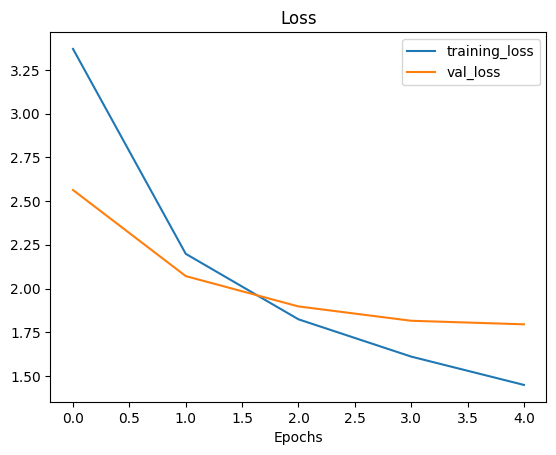

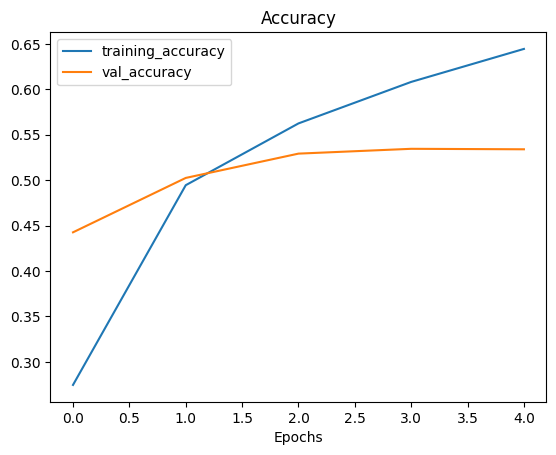

In [22]:
plot_loss_curves(history_0)

# Fine-tuning

In [24]:
backbone.trainable = True
for layer in backbone.layers[:-5]:
  layer.trainable = False

In [25]:
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [26]:
for num, layer in enumerate(backbone.layers):
  print(num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [27]:
fine_tune_epochs = initial_epoch + 5

history_fine_tune = model_0.fit(train_data_all_10_percent,
                                epochs=fine_tune_epochs,
                                validation_data=test_data,
                                validation_steps=int(0.15 * len(test_data)),
                                initial_epoch=history_0.epoch[-1],
                                callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 86s 324ms/step - loss: 1.2090 - accuracy: 0.6821 - val_loss: 1.7491 - val_accuracy: 0.5381
Epoch 6/10
237/237 [==============================] - 64s 269ms/step - loss: 1.0861 - accuracy: 0.7130 - val_loss: 1.7612 - val_accuracy: 0.5405
Epoch 7/10
237/237 [==============================] - 59s 248ms/step - loss: 1.0103 - accuracy: 0.7282 - val_loss: 1.7650 - val_accuracy: 0.5408
Epoch 8/10
237/237 [==============================] - 58s 243ms/step - loss: 0.9576 - accuracy: 0.7440 - val_loss: 1.7557 - val_accuracy: 0.5477
Epoch 9/10
237/237 [==============================] - 57s 239ms/step - loss: 0.8770 - accuracy: 0.7707 - val_loss: 1.7352 - val_accuracy: 0.5501
Epoch 10/10
237/237 [==============================] - 60s 251ms/step - loss: 0.8300 - accuracy: 0.7776 - val_loss: 1.7591 - val_accuracy: 0.5461


In [28]:
fine_tune_results = model_0.evaluate(test_data)

790/790 [==============================] - 61s 77ms/step - loss: 1.4970 - accuracy: 0.6055


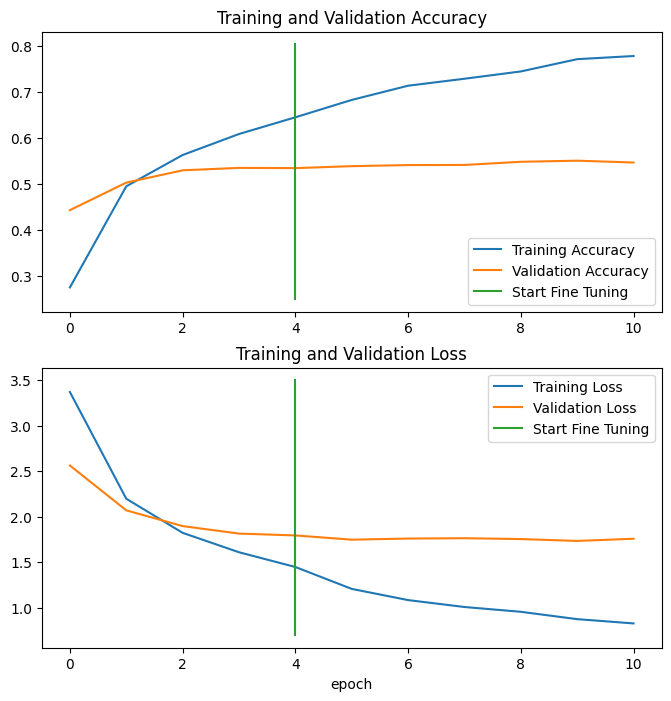

In [30]:
compare_historys(original_history=history_0,
                 new_history=history_fine_tune,
                 initial_epochs=5)

## saving and loading our model

In [31]:
model_0.save("101_food_classes_saved_big_dog_model")

In [33]:
loaded_model = tf.keras.models.load_model("101_food_classes_saved_big_dog_model/")

In [34]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 61s 75ms/step - loss: 1.4970 - accuracy: 0.6055


[1.4969772100448608, 0.6054653525352478]

In [35]:
fine_tune_results

[1.4969772100448608, 0.6054653525352478]